In [34]:
from regressors import *
import pickle
import pandas as pd

In [35]:
ensembleregression = EnsembleRegression(n_regressors=5,n_variables=3, eps=3, decision_boundary=0.6, global_search=False)
spatialcomparision = SpatialComparision()

In [36]:
n_stations = 400
n_timesteps= 100
k = 5
p_noise_stations = 0.01
p_noise_timesteps= 0.01


data = Tempearture_DWD(n_stations, n_timesteps, k, p_noise_stations=p_noise_stations, p_noise_timesteps= p_noise_timesteps)
validatorNew= Executor(data, ensembleregression)
validatorOld = Executor(data, spatialcomparision)
resultNew = validatorNew.evaluate_validator()  
resultOld = validatorOld.evaluate_validator()  




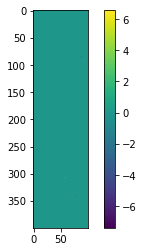

In [37]:
plt.imshow(data.matrix_noises)
plt.colorbar()

In [38]:
ts_data = data.ts_data
neighbor = data._neighbor

In [39]:
def regression_predict_w_randomness(ts_data, i, global_search=False, display=False) :     
    max_score = -np.inf
    max_iteration = 500
    n_iter = 0 
    thr = 0.9
    while True :
        if global_search : 
            candidate = np.arange(ts_data.shape[0])
            candidate = np.delete(candidate, i)                      
        else : 
            candidate = data._neighbor[i]      
        idx_stations = np.random.choice(candidate, size=3, replace=False)
        idx_timesteps = np.random.choice(np.arange(ts_data.shape[1]), size= round(ts_data.shape[1]/2), replace=True)
        idx_timesteps.sort()

        y = ts_data[i]
        X = ts_data[idx_stations]
        reg = LinearRegression().fit(X.T[idx_timesteps],y[idx_timesteps])
        score = reg.score(X.T[idx_timesteps],y[idx_timesteps])


        if score > max_score :
            max_score = score
            max_idx_stations = idx_stations
            max_idx_timesteps = idx_timesteps

        if n_iter >= max_iteration :                 
            X = ts_data[max_idx_stations]
            reg = LinearRegression().fit(X.T[max_idx_timesteps],y[max_idx_timesteps])
            pred = reg.predict(X.T)
            gap = abs(pred - y)
            if display : 
                print("for {} iteration, cannot find more than {}. the best upto now is {}".format(max_iteration, thr, max_score))
            break
        if (score > thr) : 
            pred = reg.predict(X.T)
            gap = pred - y
            if display : 
                print(score)
            break
        n_iter += 1
    if display : 
        plt.figure(figsize=(20,5))
        plt.plot(X.T, color='grey')
        plt.plot(y)
        plt.plot(pred, color='black')
        # plt.plot(gap, color='blue')
    return pred

In [40]:
def regression_predict_w_neighbor(ts_data, i) :     
    y = ts_data[i]
    X = ts_data[neighbor[i]]
    reg = LinearRegression().fit(X.T,y)
    score = reg.score(X.T,y)
    print(score)
    pred = reg.predict(X.T)
    gap2 = abs(pred - y)
    plt.figure(figsize=(20,5))
    plt.plot(X.T, color='grey')
    plt.plot(y)
    plt.plot(pred, color='black')
    # plt.plot(gap, color='blue')
    return pred

In [41]:
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [42]:
def evaluate_predictor(function, ts_data, i, global_search=False, display = False) : 
    pred = function(ts_data, i, global_search=global_search, display=display)

    gap = pred - ts_data[i]
    gap_between_rawdata = pred - data._ts_rawdata[i]
    
    gap_mean = np.mean(gap)
    gap_std = max(np.std(gap),2)

    idx = (gap >= gap_mean +  2 * gap_std) | (gap <= gap_mean -  2 * gap_std)
    pred_by_neighbor_randomness = np.where(idx == True )[0]
    
    if display  : 
        print("SSE between rawdata", math.sqrt(sum(gap_between_rawdata**2)))
        print(pred_by_neighbor_randomness)
        print("LevenshteinDistance", levenshteinDistance(answer, pred_by_neighbor_randomness))
        plt.plot(idx, color='red')
    return idx

# Random Selection

In [43]:
data._picked_stations

array([ 85, 256, 307, 342])

In [61]:
i = np.random.choice(data._picked_stations)
# i = np.random.choice(range(len(ts_data)))
try : 
    answer = sorted(data.dic_timesteps[i])
except :
    answer = []
    
pred_by_new = [int(s.split('_')[1]) for s in validatorNew.validate(i)]
pred_by_old = [int(s.split('_')[1]) for s in validatorOld.validate(i)]
print("selected station", i)
print("neighbor stations with noise: ", [s for s in neighbor[i] if s in data._picked_stations])
print("answer:         ",answer)
print("predicted by new",pred_by_new, levenshteinDistance(answer, pred_by_new ))
print("predicted by old",pred_by_old, levenshteinDistance(answer, pred_by_old ))

selected station 342
neighbor stations with noise:  []
answer:          [78]
predicted by new [78] 0
predicted by old [78, 91] 1


0.9511847820474656
SSE between rawdata 6.949651549542017
[78]
LevenshteinDistance 0


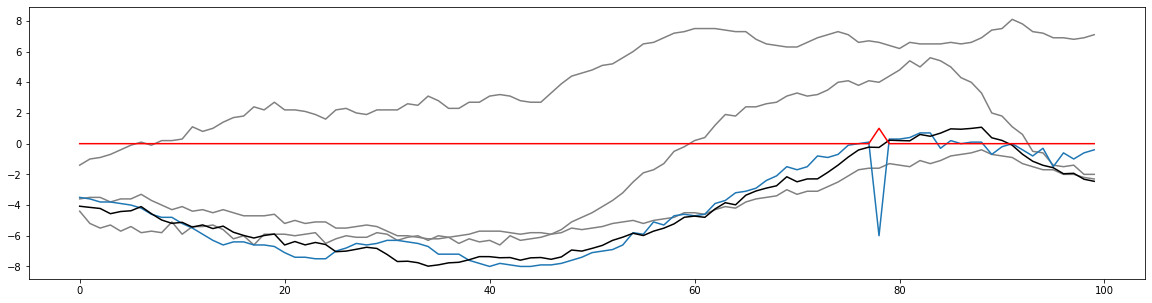

In [62]:
_ = evaluate_predictor(regression_predict_w_randomness, ts_data, i, global_search = True, display=True)

In [ ]:
score_idx = np.zeros(ts_data.shape[1])
for j in range(10) : 
    score_idx += evaluate_predictor(regression_predict_w_randomness, ts_data, i, global_search = False, display=False)

In [ ]:
np.where(score_idx > 6)[0]

In [ ]:
(-score_idx).argsort()[:3]

In [ ]:
np.where(gap>1)[0]

In [ ]:
import copy

In [ ]:

def regression(X,y) : 
    reg = LinearRegression().fit(X.T,y)
    score = reg.score(X.T,y)
    pred = reg.predict(X.T)
    print(score)
    plt.plot(pred,color="red")
    plt.plot(y)
    plt.figure()
    gap = abs(pred-y)
    plt.plot(gap)
    return pred




In [ ]:
def correct_values(pred, y): 
    gap = abs(pred - y)
    idx_for_correction = np.where(gap > np.mean(gap) + 2 * np.std(gap))[0]
    corrected_y = copy.deepcopy(y)
    if len(idx_for_correction) < 1 : 
        print("no more correction possible")
        return y
    else : 
        print("idx for correction", idx_for_correction)
    for i in idx_for_correction : 
        corrected_y[i] = pred[i]
    return corrected_y

In [ ]:
validatorNew.result


In [ ]:
i=78
print(i, neighbor[i])
for j in neighbor[i] : 
    if j in data._picked_stations : 
        print(j, "is in the noise stations")


In [ ]:

X = ts_data[neighbor[i]]
y = ts_data[i]
pred = regression(X,y)
corrected_y = correct_values(pred, y)
ts_data[i] = corrected_y

In [ ]:
data.ts_data = ts_data

In [ ]:
pre

In [ ]:
data.lst_station_timestep

In [ ]:
validatorNew.evaluate_validator()

In [ ]:
corrected_ts_data = copy.deepcopy(ts_data)

In [ ]:
corrected_ts_data[i] = corrected_y

In [ ]:
data.ts_data = corrected_ts_data

In [ ]:
validatorNew= Validator(data, ensembleregression)


In [ ]:
i

In [ ]:
validatorNew.evaluate_validator()

In [ ]:
pred = regression(X,y)
corrected_y = correct_values(pred, y)

In [ ]:
y[3] = pred[3]
y[9] = pred[9]

In [ ]:
reg = LinearRegression().fit(X.T,y)
score = reg.score(X.T,y)
pred = reg.predict(X.T)
gap = pred - y 

In [ ]:
plt.plot(pred)
plt.plot(y, color='red')
# plt.plot(X.T, color='grey')

In [ ]:
y[3] = pred[3]
y[9] = pred[9]

In [ ]:
reg = LinearRegression().fit(X.T,y)
score = reg.score(X.T,y)
pred = reg.predict(X.T)
gap = pred - y 

In [ ]:
score

In [ ]:
plt.plot(pred)
plt.plot(y, color='red')
# plt.plot(X.T, color='grey')

In [ ]:
plt.plot(gap)

In [ ]:
plt.plot(ts_data[i])
plt.plot(ts_data[neighbor[i]].T, color='grey')


In [ ]:
reg

In [ ]:
ts_data = data.ts_data

In [ ]:
print(resultNew['precision'], resultOld['precision'])
print(resultNew['recall'], resultOld['recall'])
print(resultNew['f1'], resultOld['f1'])


In [ ]:
lst_p_noise_stations = np.arange(0.01, 0.5, 0.02)
lst_p_timesteps = np.arange(0.01, 0.5, 0.02)

n_stations = 400
n_timesteps = 100
k = 5
p_noise_stations = 0.40
p_noise_timesteps = 0.1

RESULT = []
for p_noise_stations in lst_p_noise_stations : 
    for p_noise_timesteps in lst_p_timesteps : 
        data = Tempearture_DWD(n_stations, n_timesteps, k, p_noise_stations=p_noise_stations, p_noise_timesteps= p_noise_timesteps)
        validatorNew= Validator(data, ensembleregression)
#         validatorOld = Validator(data, spatialcomparision)
        resultNew = validatorNew.evaluate_validator()        
        result = [n_stations, n_timesteps, k, p_noise_stations, p_noise_timesteps, resultNew['precision'], resultNew['recall'], resultNew['f1']]
        print(result)
        RESULT.append(result)


In [ ]:

resultOld = validatorOld.evaluate_validator()
print("New", resultNew['precision'], resultNew['recall'], resultNew['f1'])
print("Old", resultOld['precision'], resultOld['recall'], resultOld['f1'])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['Precision', 'Recall', 'F1']
New_validator = [resultNew['precision'], resultNew['recall'], resultNew['f1']]
Old_validator = [resultOld['precision'], resultOld['recall'], resultOld['f1']]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, New_validator, width, label='New')
rects2 = ax.bar(x + width/2, Old_validator, width, label='Old')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores comparision between new and old')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()

In [ ]:
noise = data.ts_data - data._ts_rawdata
plt.figure(figsize=(10,10))
plt.imshow(noise)
plt.colorbar()


In [ ]:
ts_data = data.ts_data 

In [ ]:
stations_w_noises = set([int(x.split('_')[0]) for x in data.lst_station_timestep])

In [ ]:
validator1.evaluate_validator()

In [ ]:
validator3.evaluate_validator()

# stations with no problems 

In [ ]:

# def find_nearest_stations(i, ts_data, neighbor, max_iteration) : 
def find_nearest_stations(i, ts_data,  max_iteration) : 
    iteration = 0
    max_score = -np.inf
    while True  :
        candidate = list(range(len(ts_data)))
        candidate.remove(i)
#         candidate = neighbor[i]
        idx = np.random.choice(candidate, size=3)
    #     print(idx)
        X = ts_data[idx]
        y = ts_data[i]
        reg = LinearRegression().fit(X.T, y)
        score = reg.score(X.T,y)
        if score >= max_score :
            max_score = score 
            max_idx = idx
        if score >= 0.9 : 
#             print(i, score, idx,iteration )
            return max_score, max_idx

        iteration += 1
    #     print(idx, score, iteration)
        if iteration >= max_iteration : 
#             print("cannot find more than .9, the best so far")
#             plt.plot(y)
#             plt.plot(X.T, color='grey')
            return max_score, max_idx
    

In [ ]:
result = np.zeros(len(data.ts_data))
max_iteration = 100
for i in range(len(data.ts_data)) : 
    max_score, _ = find_nearest_stations(i, data.ts_data, max_iteration)
    result[i] = max_score

In [ ]:
lst_noise_stations = list(set([int(x.split('_')[0]) for x in data.lst_station_timestep]))

In [ ]:
lst_noise_stations.sort()

In [ ]:
lst_noise_stations

In [ ]:
result[12]

In [ ]:
lst_noise_stations

In [ ]:
lst_suspected_stations

In [ ]:
lst_suspected_stations = np.where(result<0.3)[0].tolist()

In [ ]:
s_stations =0 
for s in lst_suspected_stations : 
    if s in lst_noise_stations : 
        s_stations += 1


In [ ]:
len(lst_suspected_stations)

In [ ]:
s_stations =0 
for s in lst_noise_stations : 
    if s in lst_suspected_stations : 
        s_stations += 1


In [ ]:
len(lst_noise_stations)

In [ ]:
s_stations

In [ ]:
max_iteration = 100


In [ ]:
while True : 
    i = random.choice(range(len(ts_data)))
    if i not in stations_w_noises : 
        break
print(i)


In [ ]:
data.lst_station_timestep

In [ ]:
s = 0
for i in range(len(ts_data)) : 
    max_score, max_idx = find_nearest_stations(i, ts_data, neighbor, max_iteration)
    if max_score <0.5 : 
        s += 1
        print(i)
print(s, len(ts_data), s/len(ts_data)*100)
    

In [ ]:
s = 0
for i in range(len(ts_data)) : 
    max_score, max_idx = find_nearest_stations(i, data._ts_rawdata, neighbor, max_iteration)
    if max_score <=0.5 : 
        s += 1
        print(i)
print(s, len(ts_data), s/len(ts_data)*100)
    

In [ ]:
plt.plot(y)
plt.plot(X.T, color='grey')
plt.plot(reg.predict(X.T), color='red')
plt.legend(['actual','neighbor','predict'])

In [ ]:
gap = reg.predict(X.T) - y

In [ ]:
np.mean(gap), np.std(gap)

In [ ]:

plt.plot(gap)

In [ ]:
neighbor = data._neighbor

In [ ]:

validator1.validate(i)

In [ ]:
plt.plot(ts_data[i])
plt.plot(ts_data[neighbor[i]].T, color='grey')

In [ ]:
data = data._ts_rawdata


In [ ]:
plt.plot(ts_data[i])
plt.plot(ts_data[idx].T, color='grey')

In [ ]:

gap = reg.predict(X.T) - y 
mean = np.mean(gap)
sd = np.std(gap)
print(mean, sd)
# plt.plot(gap)

plt.plot(mean + 2* sd <= gap, color='red')
plt.plot(gap<= mean - 2* sd, color='red')


In [ ]:
max_score = -np.inf
width = 50
target_data = ts_data[i]

for j in range(10000) : 
    idx_samples = np.random.choice(range(50), size = 5)
    idx_stations = np.random.choice(range(n_stations), size=3)
    y = target_data[idx_samples]
    X = ts_data[idx_stations][:,idx_samples]

    reg =  LinearRegression().fit(X.T, y)
    score = reg.score(X.T,y)
    if score >= max_score : 
        max_idx = [idx_stations, idx_samples]    

print(i, score, max_idx)

In [ ]:
max_score = -np.inf
width = 50
target_data = ts_data[i]
N = 1000

result = np.zeros((N, ts_data.shape[1])) 

for j in range(N) : 
    idx_samples = np.random.choice(range(50), size = 10)
    idx_stations = np.random.choice(range(n_stations), size=3)
    y = target_data
    X = ts_data[idx_stations]

    reg =  LinearRegression().fit(X[:,idx_samples].T, y[idx_samples])
    result[j] = reg.predict(X.T) 


In [ ]:
# plt.plot(np.mean(result, axis=0), color='grey')
# plt.plot(y, color='red')
gap = abs(np.mean(result, axis=0) - y)
plt.plot(gap)

In [ ]:
[int(x.split('_')[1]) for x in data.lst_station_timestep if x.startswith(str(i))]

In [ ]:
gap_matrix = ts_data - data._ts_rawdata

In [ ]:
validator2.evaluate_validator()

In [ ]:
[x for x in data.lst_station_timestep if x.startswith(str(i) + '_')]

In [ ]:
plt.plot(y)
plt.plot(X.T, color='grey')
plt.plot(reg.predict(X.T), color='red')
# plt.plot(reg.predict(ts_data[idx_stations].T), color='red')

In [ ]:
gap_matrix[i,36]

In [ ]:
validator1.validate(i)


In [ ]:
gap = reg.predict(ts_data[idx_stations].T) - target_data
gap_mean = np.mean(gap)
gap_std = np.std(gap)
plt.plot(reg.predict(ts_data[idx_stations].T) - target_data)
plt.figure()
lst_candidate_noises = np.append((np.where(gap_mean + gap_std <= gap)[0]), np.where(gap_mean - gap_std >= gap)[0])
lst_candidate_noises.sort()
print(lst_candidate_noises)

In [ ]:
len(ts_data[281])

In [ ]:
plt.plot(ts_data[i])
plt.plot(ts_data[idx].T, color='grey')

In [ ]:
data.lst_station_timestep

In [ ]:
validator1.evaluate_validator()

In [ ]:
validator2.evaluate_validator()

In [ ]:
validator3.evaluate_validator()

In [ ]:
i = np.random.choice(list(set([int(i.split('_')[0]) for i in data.lst_station_timestep])))
plt.figure(figsize=(20,5))
plt.plot(data.ts_data[data._neighbor[i]].T, color='grey')
plt.plot(data.ts_data[i], color='red')
plt.title(i)
print([x for x in data.lst_station_timestep if x.startswith(str(i) + '_')])
print(validator1.validate(i))
print(validator2.validate(i))
print(validator3.validate(i))

In [ ]:
df_corr = pd.DataFrame(data.ts_data.T).corr()

In [ ]:
idx_df_corr = df_corr.values.argsort()

In [ ]:
data.lst_station_timestep

In [ ]:
i=297
df_corr.loc[i,idx_df_corr[i]]

In [ ]:
plt.plot(data.ts_data[297], color='red')
plt.plot(data.ts_data[[322,259,309, 181, 8, 220]].T, color='grey')

In [ ]:
gap = data.ts_data - data._ts_rawdata

In [ ]:
plt.plot(gap[297])

In [ ]:
# X = data.ts_data[[322,259,309]]
X = data.ts_data[[322,259,309, 181, 181, 8, 220]] 
y = data.ts_data[297]
reg = LinearRegression().fit(X.T, y)
print(reg.score(X.T,y))
predict = reg.predict(X.T)
plt.plot(predict , color='grey')
plt.plot(y, color='red')
plt.figure()
plt.plot((predict - y)>2 )

In [ ]:
plt.plot(data.ts_data[297])
plt.plot(data.ts_data[[8,220]].T, color='grey')

In [ ]:
X = data.ts_data[[293,23]]
y = data.ts_data[0]
reg = LinearRegression().fit(X.T, y)
print("R^2:", reg.score(X.T, y))
print("SquaredSum:", sum((reg.predict(X.T) - y)**2))

In [ ]:
X = data.ts_data[[313,147]]
y = data.ts_data[0]
reg = LinearRegression().fit(X.T, y)
print("R^2:", reg.score(X.T, y))
print("SquaredSum:", sum((reg.predict(X.T) - y)**2))

In [ ]:
IDX.shape

In [ ]:
df_corr.loc[74, IDX[]]

In [ ]:
data.lst_station_timestep

In [ ]:
validator1.spatial_reference(data._metadata[0], data._metadata[313])['distance']/1000

In [ ]:
reg.score(X.T, y)
sum((reg.predict(X.T) - y)**2)

In [ ]:
plt.plot(data.ts_data[0])
plt.plot(data.ts_data[[293,23]].T)

In [ ]:
IDX = abs(pd.DataFrame(data.ts_data.T).corr().values).argsort()[-10:]

In [ ]:
data.ts_data[IDX[0]]

In [ ]:
plt.plot(np.dot(PRED.T, SCORE) - ts_data[i])

In [ ]:
SCORE[7]

In [ ]:
idx_variables

In [ ]:
ts_data[neighbor[i]][idx_variables]

In [ ]:
plt.plot(ts_data[0])
plt.plot(ts_data[neighbor[0]].T, color='grey')

In [ ]:
data = data.ts_data
neighbor = data._neighbor

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(data[0], color='red')
plt.plot(data[neighbor[0]].T, color='grey')

In [ ]:
data[0]

In [ ]:
pd.concat([pd.DataFrame(data[0]), pd.DataFrame(data[neighbor[0]]).T], axis=1).corr()

In [ ]:
data._lst

In [ ]:
import random
idx = random.choices(neighbor[0], k=3)
X = data[idx]
y = data[0]

In [ ]:

reg = LinearRegression().fit(X.T, y)

In [ ]:
reg.score(X.T, y)

In [ ]:
plt.plot(reg.predict(X.T))
plt.plot(y)
# plt.plot(reg.predict(X.T) - y)

In [ ]:
pd.DataFrame(data[neighbor[0]]).corr()

In [ ]:
data.tsneighbor[0]

In [ ]:
import time
RESULT = [] 
for n_timesteps in range(1000, 10000, 1000) : 
    print(n_stations, n_timesteps)
    ensembleregression = EnsembleRegression(n_regressors=5,n_variables=3,eps=4, decision_boundary=0.7)    
    data = Tempearture_DWD(n_stations, n_timesteps, k, p_noise=0.01)
    # data = RandomData(20,20,5, p_noise = 0.01)
    validator1 = Validator(data,ensembleregression)
    validator2 = Validator(data,spatialcomparision)
    start = time.time()
    validator1.evaluate_validator()
    end = time.time() - start
    
    print(end)
    RESULT.append(end)

In [ ]:
import time
RESULT2 = [] 
for n_timesteps in range(1000, 10000, 1000) : 
    ensembleregression = EnsembleRegression(n_regressors=5,n_variables=3,eps=4, decision_boundary=0.7)
    spatialcomparision = SpatialComparision()
    data = Tempearture_DWD(n_stations, n_timesteps, k, p_noise=0.1)
    # data = RandomData(20,20,5, p_noise = 0.01)
    validator1 = Validator(data,ensembleregression)
    validator2 = Validator(data,spatialcomparision)
    start = time.time()
    validator1.evaluate_validator()
    RESULT2.append(time.time() - start)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(RESULT)
plt.plot(RESULT2)
plt.legend(['new','old'])

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(data.ts_data)

In [ ]:
validator1.evaluate_validator()

In [ ]:
validator2.evaluate_validator()

In [ ]:
%%timeit
validator1.evaluate_validator()

In [ ]:
%%timeit
validator1.evaluate_validator()

In [ ]:
%%timeit
validator1.evaluate_validator()

In [ ]:
%%timeit
validator2.evaluate_validator()

In [ ]:
%%timeit
validator2.evaluate_validator()

In [ ]:
%%timeit
validator2.evaluate_validator()

In [ ]:
s = int(random.choice(data.lst_station_timestep).split('_')[0])

plt.figure(figsize=(20,5))
plt.plot(data.ts_data[s], color='red')
plt.plot(data.ts_data[data._neighbor[s]].T, color='grey')
plt.title(s)
print("answer", [x for x in data.lst_station_timestep if x.startswith(str(s) + '_')])
print("new_idea", validator1.validate(s))
print("exsiting_idea", validator2.validate(s))

In [ ]:

plt.scatter(data._metadata[:,1], data._metadata[:,2], color='grey')
plt.scatter(data._metadata[s,1], data._metadata[s,2], color='red')
plt.scatter(data._metadata[data._neighbor[s]][:,1], data._metadata[data._neighbor[s]][:,2], color='blue')

In [ ]:
for d in data._metadata[data._neighbor[s]] : 
    
    print(validator1.spatial_reference(data._metadata[s], d)['distance'])

In [ ]:
d = data._metadata[:,1:]

In [ ]:
distance_matrix(d,d)[0]

In [ ]:
distance_matrix(d,d)[0][distance_matrix(d,d)[0].argsort()]

In [ ]:
data._metadata[data._neighbor[s]]

In [ ]:
df = pickle.load(open('data_dvd_reduced.p','rb'))
df_metadata = pickle.load(open('metadata.p', 'rb'))
metadata = df_metadata.values[:400]
neighbor = create_neighor_list(metadata[:,1:], k=5)
ts_rawdata = df.values[:400]
ts_preprocessed_data = preprocess_data(ts_rawdata)[:,5000:7000]

In [ ]:
ts_data, ANSWER, lst_noises = add_noise(ts_preprocessed_data, 0.10, 3, 10)


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(ts_data)

In [ ]:
eps=4
n_regressors = 5
n_variables = 3


In [ ]:
RESULT = []
for i in range(100) : 
    result = evaluator(ts_data, ANSWER, neighbor, classifier = regression_based_outlier_detection, n_regressors=n_regressors, n_variables=n_variables, eps=eps)['f1']
    RESULT.append(result)
print(np.mean(RESULT))


In [ ]:
RESULT = []
for i in range(100) : 
    result = evaluator(ts_data, ANSWER, neighbor, classifier = regression_based_outlier_detection2, n_regressors=n_regressors, n_variables=n_variables, eps=eps)['f1']
    RESULT.append(result)
print(np.mean(RESULT))


In [ ]:
RESULT = []
for i in range(100) : 
    result = evaluator(ts_data, ANSWER, neighbor, classifier = regression_based_outlier_detection3, n_regressors=n_regressors, n_variables=n_variables, eps=eps)['f1']
    RESULT.append(result)
print(np.mean(RESULT))


In [ ]:
%%timeit
evaluator(ts_data, ANSWER, neighbor, classifier = spatialcomparision, n_regressors=n_regressors, n_variables=n_variables, eps=eps)['f1']

In [ ]:
%%timeit
evaluator(ts_data, ANSWER, neighbor, classifier = regression_based_outlier_detection, n_regressors=n_regressors, n_variables=n_variables, eps=eps)['f1']

In [ ]:
%%timeit
evaluator(ts_data, ANSWER, neighbor, classifier = regression_based_outlier_detection2, n_regressors=n_regressors, n_variables=n_variables, eps=eps)['f1']

In [ ]:
%%timeit
evaluator(ts_data, ANSWER, neighbor, classifier = regression_based_outlier_detection3, n_regressors=n_regressors, n_variables=n_variables, eps=eps)['f1']

In [ ]:
STAT = evaluator(ts_data, ANSWER, neighbor, classifier = spatialcomparision)
STAT

In [ ]:
s = random.choice(list(set([k[0] for k,v in lst_noises.items()])))

plt.figure(figsize=(20,5))
plt.plot(ts_data[s], color='red')
plt.plot(ts_data[neighbor[s]].T , color='grey')
plt.title(s)

d = [(k,v) for k,v in sorted(lst_noises.items(), reverse=False, key=lambda x : x[0][0]) if k[0] == s]
print([(k,v) for k,v in sorted(d, reverse=False, key=lambda x : x[0][1])])
result1 = regression_based_outlier_detection(ts_data, neighbor, s, n_regressors, n_variables, eps=eps)
result2 = regression_based_outlier_detection2(ts_data, neighbor, s, n_regressors, n_variables, eps=eps)
result3 = regression_based_outlier_detection2(ts_data, neighbor, s, n_regressors, n_variables, eps=eps)
result4 = spatialcomparision(ts_data, neighbor, s)

print("classified by new idea", result1)
# print("classified by new idea2", result2)
# print("classified by new idea3", result3)
print("classified by old idea", result4)

In [ ]:
%%timeit
spatialcomparision(ts_data, neighbor, station=s)

In [ ]:
%%timeit
regression_based_outlier_detection(ts_data, neighbor, s, n_regressors=n_regressors, n_variables=n_variables, eps=3)


In [ ]:

n_regressors = 7
result = np.empty(len(ts_data[s]))
for i in range(n_regressors) : 
    idx = random.choices(neighbor[s],k=2)
    X = ts_data[idx]
    y = ts_data[s]
    reg = LinearRegression().fit(X.T, y)
    predict = reg.intercept_ + np.dot(X.T, reg.coef_)
    result += predict    
    print(idx, reg.score(X.T, y))
result = result / n_regressors


In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(30,10))
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)

ax1.plot(ts_data[s], color='red')
ax1.plot(ts_data[neighbor[s]].T, color='grey')

ax2.plot(y, color='red')
ax2.plot(result, color='grey')


# ylim = [-1000,40]
# ax1.set_ylim(ylim)
# ax2.set_ylim(ylim)

diff = predict-y

ax3.plot(diff, color='red')


In [ ]:
def regression_based_outlier_detection2(ts_data, neighbor, station, n_regressors, n_variables, eps) :
    result = np.array([], dtype='int')
    coeffs = np.zeros((n_regressors, n_variables + 1))
    score = np.zeros(n_regressors)
    predict = np.zeros((n_regressors, ts_data.shape[1]))
    for i in range(n_regressors) : 
        idx = random.choices(neighbor[station],k=n_variables)
        y = ts_data[station] 
        X = ts_data[idx]
        reg = LinearRegression().fit(X.T, y)
        score[i] = reg.score(X.T, y)
        predict[i] = reg.intercept_ + np.dot(X.T, reg.coef_)
        
    
    print(score)
    idx = (-score).argsort()[:-1]
    score = score / score.sum()    
    return np.dot(predict[idx].T, score[idx])
    
    
    
    
    

In [ ]:
regression_based_outlier_detection2(ts_data, neighbor, s, n_regressors=10, n_variables=3, eps=2)


In [ ]:
predict

In [ ]:
score.sum()

In [ ]:
np.dot(predict.T, score)

# random test

In [ ]:
n_variables = 3
idx = random.choices(neighbor[s],k=n_variables)
print(idx)
y = ts_data[s]
X = ts_data[neighbor[s]]
reg = LinearRegression().fit(X.T, y)
predict = reg.intercept_ + np.dot(X.T, reg.coef_)
score = reg.score(X.T,y)
print(score)

In [ ]:
original = ts_rawdata[s]
predict = reg.intercept_ + np.dot(X.T, reg.coef_)
plt.plot(original)
plt.plot(predict)
plt.plot(original-predict)

In [ ]:
mean = np.mean(diff)
sd = np.std(diff)
result_stat = np.where((diff >= mean + 2* sd)  | (diff  <= mean - 2* sd ))[0]

In [ ]:
ANSWER.sort()
ANSWER

In [ ]:
result_stat